# Table of Contents

This notebook solves creates a 1D Fokker–Planck Equation Solver


1. Imports & Global Settings
2. Physical Setup: Domain, Constants, Potential
3. Fokker–Planck Tools: Drift, Gaussian IC, Equilibrium
4. Implicit Solver (Crank–Nicolson)
5. Solver Results (Static Plots for Explicit + Implicit)
6. Animation of FP Evolution
7. QRC Data Generation


### 1. Imports and Global Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from scipy.linalg import inv
from scipy.stats import norm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4


### 2. Physical Setup: Domain, Constants, Potential

In [2]:
# --- Constants ---
k = 1.380649e-23
T = 1.0/k        
kT = k * T       # kT = 1.0

a0 = 1
a1 = 1
a2 = -10
a3 = 0
a4 = 5

# Spatial domain
x_start = -1.5
x_end = 1.5
N_points = 200
x = np.linspace(x_start, x_end, N_points)
dx = (x_end - x_start) / (N_points - 1)

# U(x) Potential Function (scaled by kT)
def U(x):
    """The Potential U(x)."""
    return a0 * kT * (a4 * x**4 + a3 * x**3 + a2 * x**2 + a1 * x)

# F(x) Force Function (F = -dU/dx)
def F(x):
    """The Force F(x) = -dU/dx."""
    return -a0 * kT * (4 * a4 * x**3 + 3 * a3 * x**2 + 2 * a2 * x + a1)

# --- Initial Grid Data ---
Ux = U(x)
Fx = F(x)

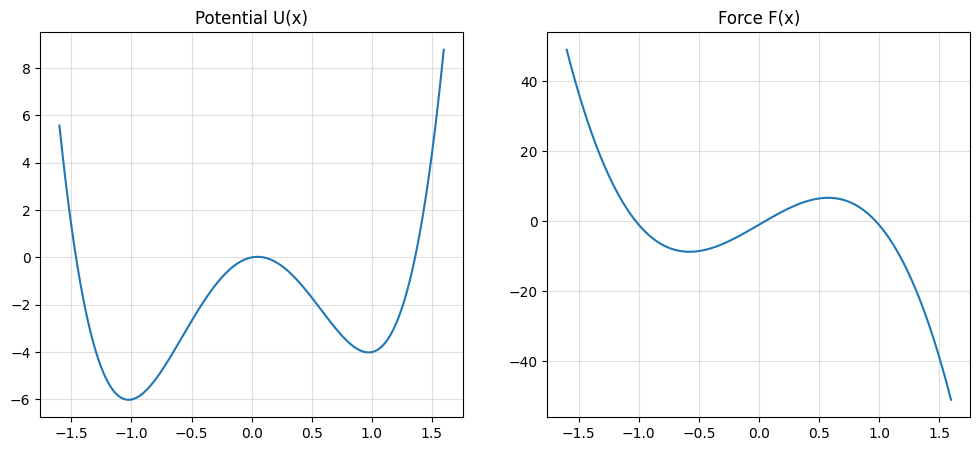

In [3]:
x_plot = np.linspace(-1.6, 1.6, 2000)
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].plot(x_plot, U(x_plot))
axs[0].set_title("Potential U(x)")

axs[1].plot(x_plot, F(x_plot))
axs[1].set_title("Force F(x)")

plt.show()


### 3. Fokker–Planck Tools: Drift, Gaussian IC, Equilibrium

In [4]:
# Initial Distribution W(x, t=0) - Gaussian
def W_gauss(mu, sigma, x):
    """Generates a normalized Gaussian initial condition W(x, t=0)."""
    Wx = norm.pdf(x, loc=mu, scale=sigma)
    
    # Enforce Dirichlet Boundary Conditions
    Wx[0] = 0
    Wx[-1] = 0
    
    # Normalize W to sum to 1
    Wx = Wx / (np.sum(Wx) * dx)
    return Wx

def drift_velocity(Fx_mesh):
    """Calculates drift velocity v = F/kT."""
    # Since kT = 1.0, v = Fx
    return Fx_mesh / kT

def equilibrium_distribution(x, U_mesh, D):
    """Calculates the theoretical equilibrium distribution W_eq(x) ~ exp(-U/D)."""
    W = np.exp(-U_mesh / D)
    return W / np.trapz(W, x)


### 4. Implicit Crank-Nicholson

In [6]:
def solve_fp_implicit(U_mesh, initial_W_mesh, D, x, total_time, snapshots):
    """
    Solves 1D Fokker-Planck using Crank-Nicolson with:
      - Advection: Upwind flux (linearized as a matrix)
      - Diffusion: Central difference
    Inputs/outputs/plotting match solve_fp_explicit.
    """
    W = initial_W_mesh.copy()
    dx = x[1] - x[0]
    N = W.size

    # Force and velocity (same as explicit)
    dUdx = np.gradient(U_mesh, dx)
    Fx = -dUdx
    v_mesh = Fx / kT  # physical velocity at nodes
    v_half = 0.5 * (v_mesh[:-1] + v_mesh[1:])  # velocity at half-nodes (length N-1)

    # --- Time step calculation ---
    dt_diff = np.inf if D <= 1e-12 else dx**2 / (2 * D)
    vmax = np.max(np.abs(v_mesh))
    dt_adv = dx / (vmax + 1e-12)
    dt = 10 * min(dt_diff, dt_adv)

    steps = int(total_time / dt)
    if steps < 1:
        steps = 1
    dt = total_time / steps

    snaps = min(snapshots, steps)
    step_interval = int(steps / snaps) if snaps > 0 else 1

    print(f"\nImplicit Crank-Nicolson Solver (D={D}): dt={dt:.2e} (Steps: {steps})")

    # --- Build sparse operator L such that dW/dt = L W ---
    # Dirichlet BCs: W[0]=W[-1]=0

    # Prepare diagonals for sparse matrix (lower, main, upper)
    lower = np.zeros(N)   # diag -1 (i-1)
    main  = np.zeros(N)   # diag  0 (i)
    upper = np.zeros(N)   # diag +1 (i+1)

    # Diffusion contribution: D * (W_{i+1} - 2 W_i + W_{i-1})/dx^2
    diff_coef = D / (dx**2)
    # For interior nodes i=1..N-2:
    lower[1:-1] += diff_coef
    main[1:-1]  += -2.0 * diff_coef
    upper[1:-1] += diff_coef

    # Advection contribution: - d/dx ( v_half * W_upwind )
    for i in range(1, N-1):
        idx_m = i-1 
        idx_p = i    

        v_p = v_half[idx_p]
        if v_p >= 0:
            main[i] += -(v_p / dx)
        else:
            upper[i] += -(v_p / dx)

        v_m = v_half[idx_m]
        if v_m >= 0:
            lower[i] += (v_m / dx)
        else:
            main[i] += (v_m / dx)

    # Assemble sparse matrix L = A (with shape NxN)
    diags = [lower[1:], main, upper[:-1]]
    offsets = [-1, 0, 1]
    L = sp.diags(diags, offsets, shape=(N, N), format='csr')

    # Enforce Dirichlet BC rows exactly (W[0]=0 and W[-1]=0):
    L = L.tolil()
    L[0, :] = 0.0
    L[-1, :] = 0.0
    L = L.tocsr()

    # Crank-Nicolson matrices:
    I = sp.eye(N, format='csr')
    M1 = (I - 0.5 * dt * L).tocsc()
    M2 = (I + 0.5 * dt * L).tocsr()

    # Factorize M1 for repeated solves
    solver = spla.factorized(M1)

    plt.figure(figsize=(9, 5))
    current_W = W.copy()

    for n in range(steps + 1):
        if n % step_interval == 0:
            label_t = "Initial" if n == 0 else f"t={n*dt:.3f}"
            plt.plot(x, current_W, label=label_t)

        if n == steps:
            break

        rhs = M2.dot(current_W)
        # enforce BCs in rhs
        rhs[0] = 0.0
        rhs[-1] = 0.0

        new_W = solver(rhs)

        if np.iscomplexobj(new_W):
            new_W = np.real(new_W)

        # enforce BCs explicitly
        new_W[0] = 0.0
        new_W[-1] = 0.0

        current_W = new_W

    plt.title(f'Implicit Solution (D={D:.4f})')
    plt.xlabel('x')
    plt.ylabel('W(x,t)')
    plt.legend()
    plt.show()

### 5. Solver Results


Implicit Crank-Nicolson Solver (D=1): dt=1.14e-03 (Steps: 220)


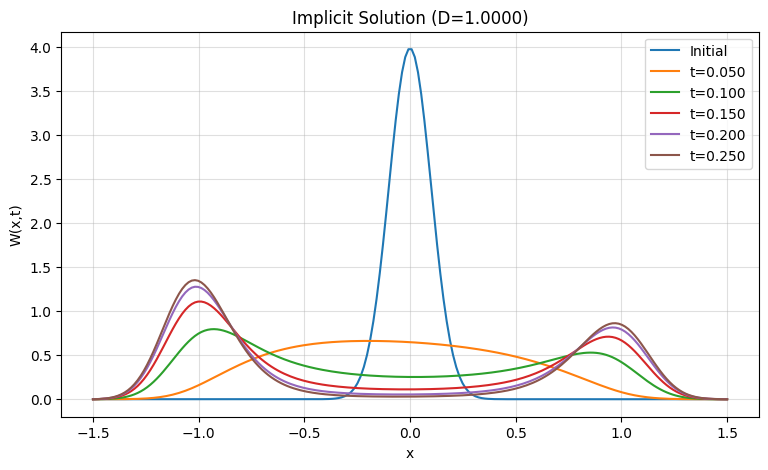


Implicit Crank-Nicolson Solver (D=0.1): dt=4.03e-03 (Steps: 62)


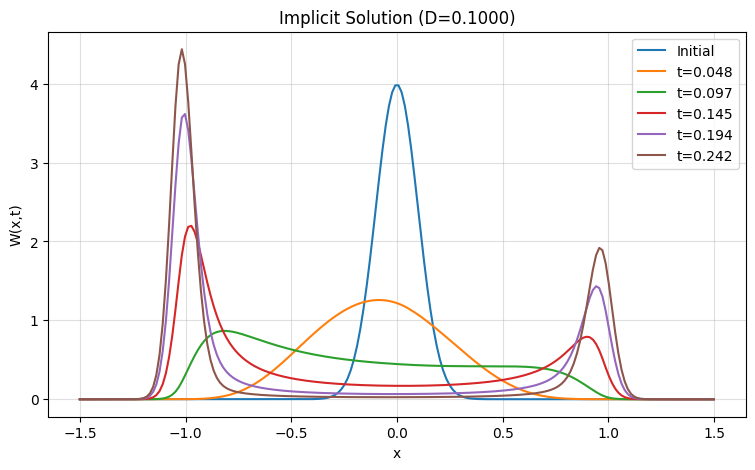


Implicit Crank-Nicolson Solver (D=0): dt=4.03e-03 (Steps: 62)


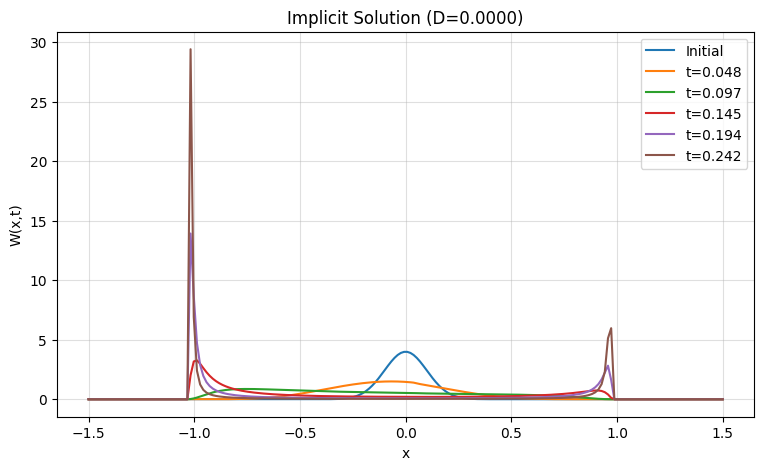

In [24]:
# Implicit Solver test cases

solve_fp_implicit(U_mesh=Ux, initial_W_mesh=Wx, D=1, x=x, total_time=0.25, snapshots=5)
solve_fp_implicit(U_mesh=Ux, initial_W_mesh=Wx, D=0.1, x=x, total_time=0.25, snapshots=5)
solve_fp_implicit(U_mesh=Ux, initial_W_mesh=Wx, D=0, x=x, total_time=0.25, snapshots=5)


### 6. Animation of FP Evolution

In [21]:
def animate_solution(
    method: str, D: float, mu: float, sigma: float, total_time: float, x: np.ndarray, n_frames: int
):
    """
    Generates an animation for the 1D Fokker-Planck equation solution.
    NOTE: Time steps for frames are now calculated to match the original solver's snapshot logic.
    """
    if method not in ['explicit', 'implicit']:
        raise ValueError("Method must be 'explicit' or 'implicit'")

    N = x.size
    U_mesh = U(x)
    
    initial_W_mesh = W_gauss(mu, sigma, x)
    current_W = initial_W_mesh.copy()

    # --- Time Step Calculation & Setup (Identical to Solver) ---
    dUdx = np.gradient(U_mesh, dx)
    Fx = -dUdx
    v_mesh = Fx / kT 

    dt_diff = np.inf if D <= 1e-12 else dx**2 / (2 * D)
    vmax = np.max(np.abs(v_mesh))
    dt_adv = dx / (vmax + 1e-12)
    dt = 3 * min(dt_diff, dt_adv)

    total_steps = int(total_time / dt)
    if total_steps < 1:
        total_steps = 1
    dt = total_time / total_steps
    
    snaps = min(n_frames, total_steps) # Use n_frames as the target number of snapshots
    step_interval = int(total_steps / snaps) if snaps > 0 else 1
    
    time_points_indices = np.arange(0, total_steps + 1, step_interval)
    
    if time_points_indices[-1] < total_steps:
         time_points_indices = np.append(time_points_indices, total_steps)
    
    # The actual number of frames collected will be len(time_points_indices)
    
    W_history = [initial_W_mesh.copy()]

    print(f"\n{method.capitalize()} Solver (D={D}): dt={dt:.2e} (Steps: {total_steps}, Frames Collected: {len(time_points_indices)})")

    # --- Core Simulation Loop ---
    
    if method == 'explicit':
        v_half = 0.5 * (v_mesh[:-1] + v_mesh[1:])
        
        for n in range(1, total_steps + 1):
            W_half = np.empty_like(v_half)
            left_vals = current_W[:-1]
            right_vals = current_W[1:]
            
            pos_mask = (v_half >= 0)
            W_half[pos_mask] = left_vals[pos_mask]
            W_half[~pos_mask] = right_vals[~pos_mask]

            J_half = v_half * W_half
            dJdx = np.zeros_like(current_W)
            dJdx[1:-1] = (J_half[1:] - J_half[:-1]) / dx
            
            d2_W_dx2 = np.zeros_like(current_W)
            d2_W_dx2[1:-1] = (current_W[2:] - 2*current_W[1:-1] + current_W[:-2]) / (dx**2)
            
            new_W = current_W.copy()
            new_W[1:-1] = current_W[1:-1] + dt * (-dJdx[1:-1] + D * d2_W_dx2[1:-1])
            
            new_W[0] = 0
            new_W[-1] = 0
            current_W = new_W

            if n in time_points_indices:
                W_history.append(current_W.copy())
    
    elif method == 'implicit':
        # Implicit setup logic remains the same
        v_half = 0.5 * (v_mesh[:-1] + v_mesh[1:])
        lower = np.zeros(N); main = np.zeros(N); upper = np.zeros(N)

        diff_coef = D / (dx**2)
        lower[1:-1] += diff_coef; main[1:-1] += -2.0 * diff_coef; upper[1:-1] += diff_coef
        
        for i in range(1, N-1):
            idx_m, idx_p = i-1, i 
            v_p, v_m = v_half[idx_p], v_half[idx_m]
            if v_p >= 0: main[i] += -(v_p / dx)
            else: upper[i] += -(v_p / dx)
            if v_m >= 0: lower[i] += (v_m / dx)
            else: main[i] += (v_m / dx)

        diags = [lower[1:], main, upper[:-1]]; offsets = [-1, 0, 1]
        L = sp.diags(diags, offsets, shape=(N, N), format='csr')
        L = L.tolil(); L[0, :] = 0.0; L[-1, :] = 0.0; L = L.tocsr()
        I = sp.eye(N, format='csr')
        M1 = (I - 0.5 * dt * L).tocsc()
        M2 = (I + 0.5 * dt * L).tocsr()
        solver = spla.factorized(M1)

        for n in range(1, total_steps + 1):
            rhs = M2.dot(current_W)
            rhs[0] = 0.0; rhs[-1] = 0.0
            new_W = solver(rhs)

            if np.iscomplexobj(new_W): new_W = np.real(new_W)
            new_W[0] = 0.0; new_W[-1] = 0.0
            current_W = new_W

            if n in time_points_indices: # Check against the new, solver-matched indices
                W_history.append(current_W.copy())


    # --- Animation Generation ---
    fig, ax = plt.subplots(figsize=(9, 5))
    line, = ax.plot(x, initial_W_mesh, label="W(x,t)")
    ax.set_title(f'{method.capitalize()} Solution (D={D:.4f})')
    ax.set_xlabel('x'); ax.set_ylabel('W(x,t)'); ax.legend(loc='upper right')
    
    max_W = np.max(initial_W_mesh) * 2.0 
    ax.set_ylim(0, max_W)

    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    def update(frame):
        # Calculate time based on the exact index of the stored frame
        current_step_index = time_points_indices[frame]
        time = current_step_index * dt 
        
        line.set_ydata(W_history[frame])
        time_text.set_text(f't={time:.3f}/{total_time:.3f}')
        return line, time_text

    ani = animation.FuncAnimation(
        fig, update, frames=len(W_history), blit=True, interval=50
    )
    plt.close(fig)

    return ani

In [25]:
# Implicit Solver Animation
anim_implicit = animate_solution(
    'implicit',
    D=0.1,
    mu=0,
    sigma=0.1,
    total_time=0.25,
    x=x,
    n_frames=500
)
print("Saving implicit animation to fp_implicit.gif...")
anim_implicit.save("fp_implicit.gif", writer="pillow", fps=15)
print("Done.")


Implicit Solver (D=0.1): dt=1.20e-03 (Steps: 208, Frames Collected: 209)
Saving implicit animation to fp_implicit.gif...
Done.


### 7. QRC Data Generation

--- Generating Data for QRC Training ---
Configuration: D=0.1, Total Time=0.25s
Sampling: Saving every 0.005s (3 internal steps per save)
Done! Saved to 'fpe_training_data.npy'.
Data Shape: (51, 200) (Rows=Time, Cols=Space)


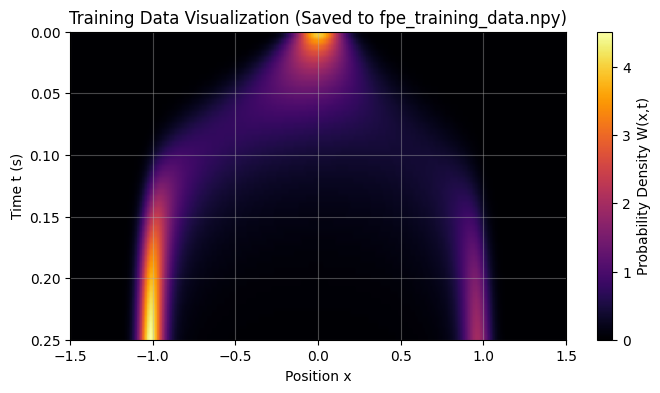

In [26]:
# --- QRC Data Generation & Export Block ---
import numpy as np

def generate_and_save_qrc_data(filename="fpe_training_data.npy"):
    print(f"--- Generating Data for QRC Training ---")
    
    # 1. Configuration
    D_train = 0.1  
    total_time_train = 0.25
    dt_save = 0.005  # Save a snapshot every 5ms
    
    # Recalculate mesh dependent variables
    Ux_gen = U(x)
    dx = x[1] - x[0]
    dUdx = np.gradient(Ux_gen, dx)
    v_mesh = -dUdx / kT
    
    # 2. Time Step Synchronization
    dt_diff = dx**2 / (2 * D_train) if D_train > 0 else 1e-5
    vmax = np.max(np.abs(v_mesh))
    dt_adv = dx / (vmax + 1e-12)
    
    # Base heuristic for stability
    dt_heuristic = 5.0 * min(dt_diff, dt_adv) 
    
    steps_per_snapshot = int(np.ceil(dt_save / dt_heuristic))
    dt_internal = dt_save / steps_per_snapshot
    
    total_snapshots = int(total_time_train / dt_save)
    
    print(f"Configuration: D={D_train}, Total Time={total_time_train}s")
    print(f"Sampling: Saving every {dt_save}s ({steps_per_snapshot} internal steps per save)")
    
    # 3. Build Matrix Operators (Crank-Nicolson)
    N = len(x)
    lower, main, upper = np.zeros(N), np.zeros(N), np.zeros(N)
    diff_coef = D_train / dx**2
    lower[1:-1] += diff_coef; main[1:-1] -= 2*diff_coef; upper[1:-1] += diff_coef
    
    v_half = 0.5 * (v_mesh[:-1] + v_mesh[1:])
    for i in range(1, N-1):
        v_p, v_m = v_half[i], v_half[i-1]
        if v_p >= 0: main[i] -= v_p/dx
        else: upper[i] -= v_p/dx
        if v_m >= 0: lower[i] += v_m/dx
        else: main[i] += v_m/dx
            
    L = sp.diags([lower[1:], main, upper[:-1]], [-1, 0, 1], shape=(N,N)).tolil()
    L[0,:] = 0; L[-1,:] = 0
    L = L.tocsr()
    
    I = sp.eye(N, format='csr')
    M1 = (I - 0.5 * dt_internal * L).tocsc()
    M2 = (I + 0.5 * dt_internal * L).tocsr()
    solver_fn = spla.factorized(M1)
    
    # 4. Simulation Loop
    # Start with fresh Gaussian
    W = W_gauss(mu=0, sigma=0.1, x=x) 
    
    data_frames = [W.copy()] # Save t=0
    
    for i in range(total_snapshots):
        # Run internal steps between snapshots
        for _ in range(steps_per_snapshot):
            rhs = M2.dot(W)
            rhs[0] = 0; rhs[-1] = 0
            W = solver_fn(rhs)
            
            # Corrections
            if np.iscomplexobj(W): W = np.real(W)
            W[0] = 0; W[-1] = 0
            
        data_frames.append(W.copy())
        
    # 5. Export
    data_stack = np.vstack(data_frames) # Shape: (TimeSteps, N_grid)
    np.save(filename, data_stack)
    
    print(f"Done! Saved to '{filename}'.")
    print(f"Data Shape: {data_stack.shape} (Rows=Time, Cols=Space)")
    
    # 6. Verification Plot
    plt.figure(figsize=(8, 4))
    # Note: 'extent' sets the axis labels to match physical time/space
    plt.imshow(data_stack, aspect='auto', origin='upper', 
               extent=[x[0], x[-1], total_time_train, 0], cmap='inferno')
    plt.colorbar(label='Probability Density W(x,t)')
    plt.title(f'Training Data Visualization (Saved to {filename})')
    plt.xlabel('Position x')
    plt.ylabel('Time t (s)')
    plt.show()

# Execute
generate_and_save_qrc_data("fpe_training_data.npy")